# Cluster Analysis
The purpose of our cluster analysis is to:
- Measure clustering & central tendency.
- Perform k-means
- Evaluate the clusters, **particularly**:
    - unhealthy vs healthy
    - study vs study

## Import libaries
### Data Processing 

In [ ]:
import pandas as pd

### Scientific computing

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

### Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustertend import ivat

### Data Visualisation

In [ ]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns

## Measure Cluster Tendency
Clustering algorithms such as k-means are used to determine the structure of multi-dimensional data. Clusters are disjoint natural groups. However, K-means will find clusters in data even if none "actually" exist. Therefore, a fundamental question before applying any clustering algorithms is: Are clusters present at all?
We will measure the clustering tendency of both datasets before subjecting it to k-means. These datasets contain the top **two principal components (2D)** and the top **three principal components (3D)**, respectively. To do this, we employ two methods:
- Hopkins's statistic  of randomness
- VAT (visual assessment of tendency)

### Hopkins statistics
Hopkins statistics {cite:p}`banerjee2004validating` tests the spatial randomness of a dataset i.e. it measures the probability that a given dataset aligns with a uniform distribution. It is based on the difference between the distance from a real point to its nearest neighbour, U, and the distance from a uniformly generated point within the data space to the nearest real data point, W.

- $H_{0}$: The dataset **is** uniformly distributed 
- $H_{1}$: The dataset **is not** uniformly distributed 

$$
H = \frac{\sum_{i=1}^{m} u_{i}^{d}}{\sum_{i=1}^{m} u_{i}^{d} + \sum_{i=1}^{m} w_{i}^{d}}
$$

If the value of the Hopkins statistic(H) is close to 1 (above 0.5), we reject $H_{0}$ and can conclude that the dataset is considered significantly clusterable.  Otherwise, we fail to reject $H_{0}$ and can conclude that the dataset is considered significantly uniformly distributed.

In [203]:
def hopkins(X):
    """
    Hopkins statistic. Code snippet:
        https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/
    """
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [204]:
dim_reduced_2d = pd.read_csv('data/dim_reduced_2d.tsv', sep="\t")
dim_reduced_3d = pd.read_csv('data/dim_reduced_3d.tsv', sep="\t")


For both datasets, we reject $H_{0}$ and can conclude that both datasets have a significant tendency to cluster.

In [316]:
print(f"2D's hopkins statistic {hopkins(dim_reduced_2d.iloc[:,2:])}")
print(f"3D's hopkins statistic {hopkins(dim_reduced_3d.iloc[:,2:])}") 

2D's hopkins statistic 0.8984590772856941
3D's hopkins statistic 0.8512912263659095


#### IVAT (visual assessment of tendency)
VAT {cite:p}`kumar2020visual` is a visual method of assessing the clustering likelihood of a dataset. VAT creates a minimum spanning tree of observations, where the pairwise distance between those observations is displayed as the black squares of an ordered dissimilarity square-shaped Map. The densely black squares on the diagonal can be understood as the number of clusters. The different shades of black provide insight on not only the numbers of clusters but also the cluster hierarchy. **Note**, This algorithm is not a substitute for cluster evaluation metrics (Elbow, Silhouette coefficient). It merely suggests if clusters exist in the datasets to avoid conducting cluster analysis on datasets in the first place. IVAT is just an improved version of the VAT algorithm that produces more precise images but is more computationally expensive.


**IVAT MAP 2D**

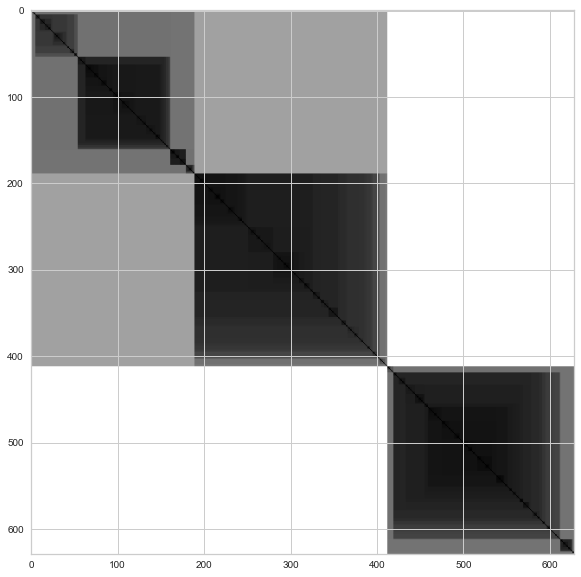

In [317]:
ivat(dim_reduced_2d.iloc[:,2:].values)



**IVAT MAP 3D**


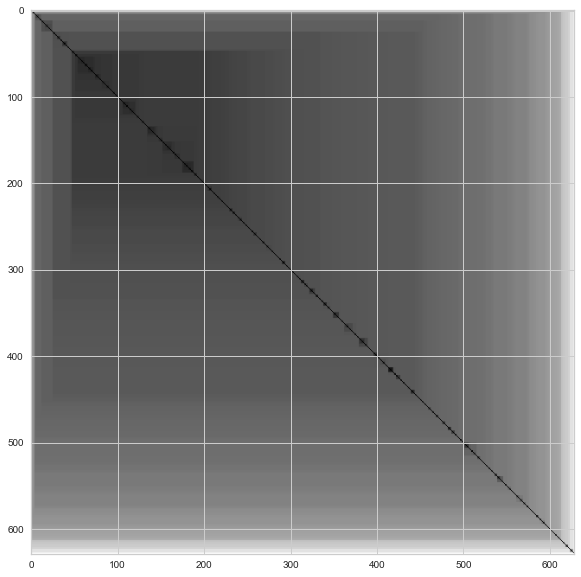

In [207]:
ivat(dim_reduced_3d.iloc[:,2:].values)

From the result of implementing IVAT, it is observed that both datsets seem to be inconclusive. However, as this algorithm is just meant to help us decide if we should go ahead with the cluster analysis or not, we will go ahead with the K-means cluster analysis as both Hopkins statistic results were significant.

## K-Means

K-means is a common clustering algorithm. Although a simple clustering algorithm, it has vast application areas, including customer segmentation and image compression. K-means is a centroid based algorithm that aims to minimize the sum of distances between the points and their respective cluster centroid.  The main steps of this algorithm are:

- **Step 1**: Choose the number (k) of clusters
- **Step 2**: Select k random points, which will become the initial centroids
- **Step 3**: Assign all data points to the nearest centroid.
- **Step 4**: Compute the centroid of the newly formed clusters by taking the
mean of data instances currently associated with that cluster.
- **Step 5**: Repeat steps 3 and 4 until either:
    - Centroids of newly formed clusters do not change
    - Points remain in the same cluster
    - Maximum number of iterations are reached

But how do we find the optimal number of clusters?
- Elbow method
- Silhouette coefficient

### Elbow method
The Elbow method calculates the error or 'distortion' between the data points ($y_{i}$) and their corresponding centroid ($ŷ_{i}$) of N data points for k clusters where k ⋹ {1...10}. The error metric used is the Sum of Squared Error (SSE):

$$
SSE = \sum_{i=1}^{N} {(y_i - ŷ_i)^2}
$$

We plot these values in an attempt to find an 'elbow' within the curve.

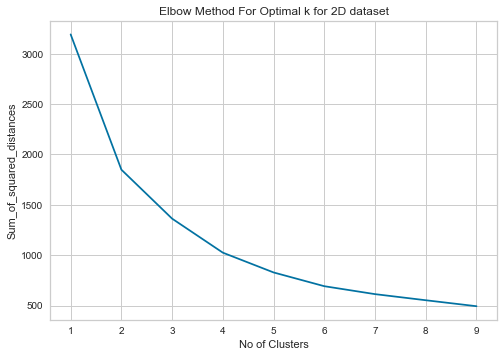

In [211]:
Sum_of_squared_distances = []
for k in range(1, 10):
    km_2d = KMeans(n_clusters=k, random_state=42)
    km_2d = km_2d.fit(dim_reduced_2d.iloc[:, 2:])
    Sum_of_squared_distances.append(km_2d.inertia_)
plt.plot(range(1, 10), Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for 2D dataset')
plt.show()

We can see that the optimal number of clusters occur at k=2 to 4.

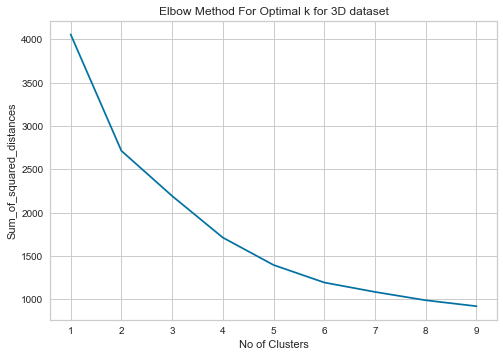

In [213]:
Sum_of_squared_distances = []
for k in range(1, 10):
    km_3d = KMeans(n_clusters=k, random_state=42)
    km_3d = km_3d.fit(dim_reduced_3d.iloc[:, 2:])
    Sum_of_squared_distances.append(km_3d.inertia_)
plt.plot(range(1, 10), Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for 3D dataset')
plt.show()


Here, determining the number of clusters is more ambiguous. Nevertheless, We believe there is a dip at k=2 to k=6 mark.

## Sillhoute method

This method is another method of finding the correct number of clusters(k). Silhouette coefficient for a particular data point ($i$) is defined as:


$$
s_{i} = \frac{b_{i} - a_{i}}{max(b_{i}, a_{i})}
$$
where:
- $s_{i}$: the silhouette coefficient, ranging from -1 to 1. A score of 1 (the best) means that data point $i$ is compact in its cluster and far away from other clusters. Conversely, the worst value is -1, while values near 0 denote overlapping clusters.
- $b_{i}$: average distance between $i$ and all the other data points in its cluster. 
- $a_{i}$: minimum average distance from $i$ to all clusters to which $i$ does not belong to

We evaluate using silhouette plots. These plots display how close each point in one cluster is to points in the neighbouring clusters.

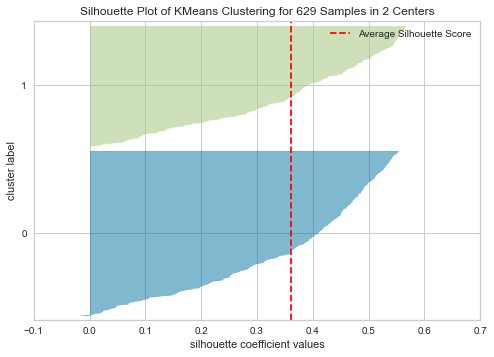

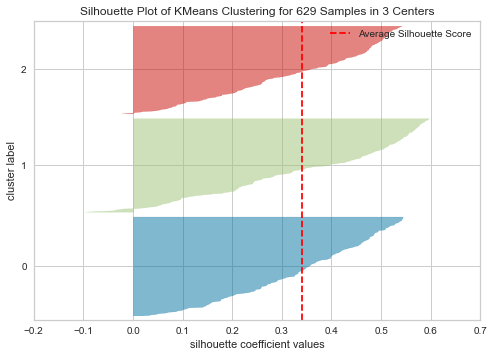

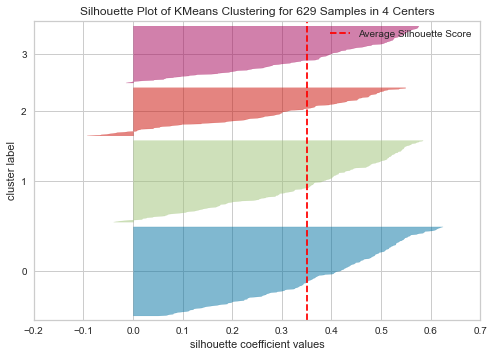

In [214]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in  range(2,5):
    km = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(dim_reduced_2d.iloc[:, 2:])
    visualizer.show()

This aligns with our previous assumption that the optimal number of clusters for the 2d dataset is 3. K=4 seem to be sub-optimal due to wide fluctuations in size of the silhouette plot. The silhouette score for each cluster is above average silhouette scores when k =2, 3 or 4. However, the fluctuation in size at 3 seems to be more uniform compared to 2. Thus, we select the optimal number of clusters as 3.  

Another method of evaluating is to simply plot the silhouette coefficient.

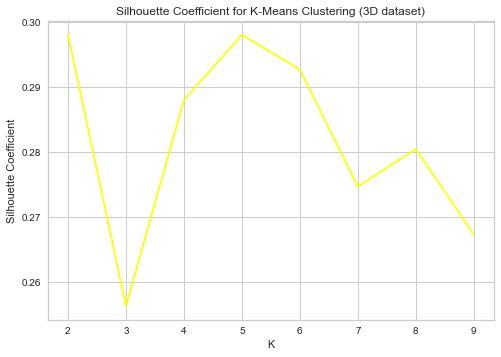

In [215]:
sill_coef = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(dim_reduced_3d.iloc[:,2:])
    sill_coef.append(silhouette_score(dim_reduced_3d.iloc[:,2:], kmeanModel.labels_))

plt.plot(K, sill_coef,  color='yellow')
plt.xlabel('K')
plt.title('Silhouette Coefficient for K-Means Clustering (3D dataset)')
plt.ylabel("Silhouette Coefficient")
plt.show()


Here, we find the optimal number of clusters to be k=2 and 5 as these values of k maximizes the silhouette coefficient.

## Findings

As mentioned previously, clusters can be considered as disjoint groups. In this context, these clusters seek to represent people with similar latent physiological processes and/or possible decision strategies. K-means clusters individuals by their choices, a health binary variable indicating if they are healthy or not and the cumulative reward at various intervals in the task. We attempt to relate the groupings to the decision-making behaviour of individual participants.

### Top 2 principal component dataset

Healthy vs Unhealthy

,1,2,3
health status,,,
amphetamine,5.0,4.0,27.0
healthy,210.0,216.0,125.0
heroin,2.0,3.0,37.0


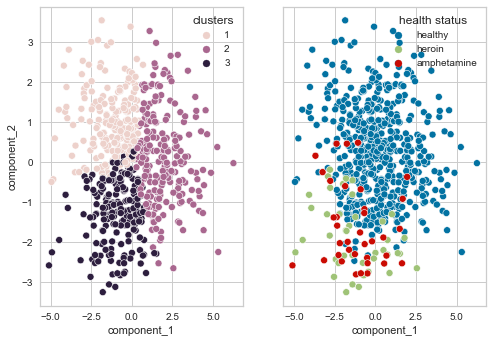

In [268]:

km_2d = KMeans(n_clusters=3, random_state=42).fit(dim_reduced_2d.iloc[:, 2:])
dim_reduced_2d["clusters"] = km_2d.labels_ + 1
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='clusters', ax=ax1)
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='health status', ax=ax2)
results_df = dim_reduced_2d[['health status', 'clusters']].set_index('health status')
results_df = results_df.apply(pd.Series.value_counts, axis=1).groupby(by=["health status"]).sum()
results_df

The majority of unhealthy individuals fall in cluster 2. With the majority of healthy individuals falling in either cluster 1 and 3. Although a significant proportion also fall in cluster 2. This lines with our hypothesis that people who suffer from subsistence issues exhibit similar decision-making deficits. 

Study vs Study

,1,2,3
study,,,
Ahn,20.0,22.0,83.0
Horstmann,89.0,66.0,7.0
Kjome,7.0,9.0,3.0
Maia,8.0,25.0,7.0
Premkumar,4.0,16.0,5.0
SteingroverInPrep,37.0,28.0,5.0
Wood,41.0,47.0,65.0
Worthy,11.0,10.0,14.0


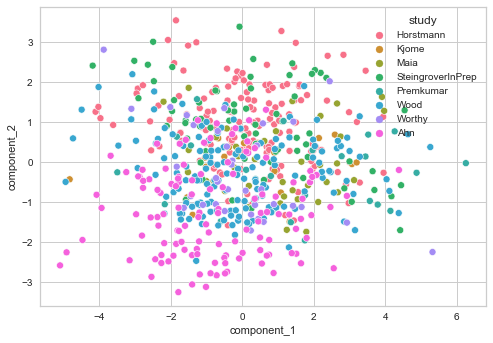

In [271]:
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='study')
results_df = dim_reduced_2d[['study', 'clusters']].set_index('study')
results_df = results_df.apply(pd.Series.value_counts, axis=1).groupby(by=["study"]).sum()
results_df

Besides the Ahn and SteingroverInPrep study, participants in each study seem to be equally distributed among the clusters. If participants could be accurately clustered by study, this would suggest that their choices are due to biases in the setup of the task rather than their behaviour. However, again, this highly depends on the assumption that k-means can accurately find the clusters within this dataset.

### Top 3 principal component dataset

**K=2**

In [311]:
def visualise_cluster_heat_map(focus_feature, k, df, cmap=None):
    """
    Visualizes the clusters as heat maps , where the squares represents 
        the number of particpants in k clusters grouped by the focus feature 
    
    :param focus_feature: focus_feature respresents the feature we want to
        drill down by i.e. health status or study
    :param k: Number of desired clusters
    :param df: Dataframe containing study, health status and the top 3 principal
        components
    :param cmap: matplotlib colormap name or object, or list of colors, optional
    """

    km_3d = KMeans(n_clusters=k, random_state=42).fit(df.iloc[:, 2:])
    df["clusters"] = km_3d.labels_ + 1
    
    df = df[[focus_feature, 'clusters']].set_index(focus_feature)
    df = df.apply(pd.Series.value_counts, axis=1).groupby(by=[focus_feature]).sum()
    sns.heatmap(df, annot=True,cmap=cmap, fmt='g')
    plt.xlabel('clusters')

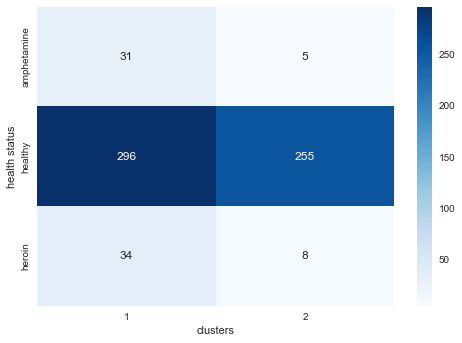

In [312]:
visualise_cluster_heat_map('health status', 2, dim_reduced_3d, 'Blues')

The healthy participants seem to be evenly spread among the two clusters. Both types of unhealthy participants have a tendency to appear in cluster 1. K-means seems to be reasonable able to cluster unhealthy patients, with 83% of unhealthy patients being clustered in the same group. However, k-means is unable to model the distinction between healthy and unhealthy individuals.

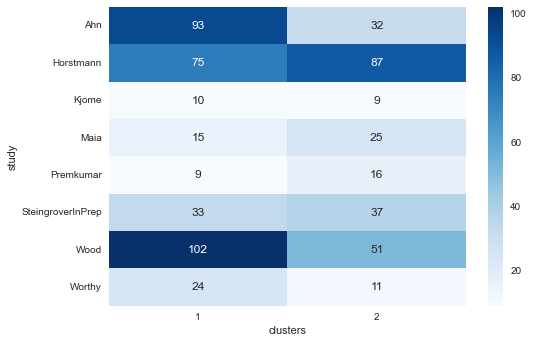

In [313]:
visualise_cluster_heat_map('study', 2, dim_reduced_3d, 'Blues')


Ahn, Wood and Worthy seem to exhibit a clear preference for one cluster over another. Otherwise, participants in the other studies are reasonably evenly spread across the two clusters.   

**K = 5**

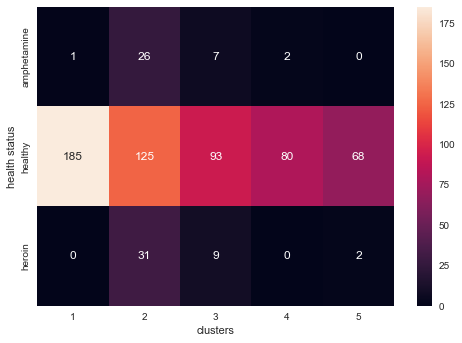

In [314]:
visualise_cluster_heat_map('health status', 5, dim_reduced_3d)

Healthy participants appear not to have a tendency to group in any cluster. For example, amphetamines users tend to group in clusters 2 and 3 and 4 whilst heroin users tend to be located in clusters 2 ,3 and 5. Interestingly, even with a more significant number of cluster's, k-means groups the majority of unhealthy individuals in the same cluster (ie.e no distinction between opioid and stimulant dependents).

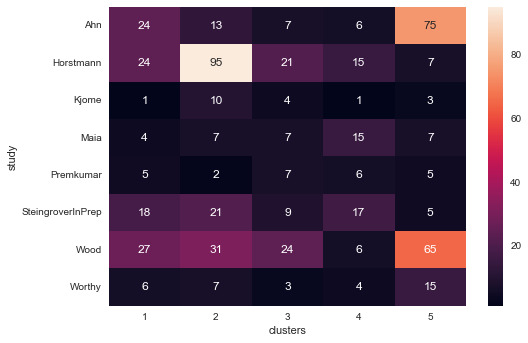

In [315]:
visualise_cluster_heat_map('study', 5, dim_reduced_3d)

Ahn, Horstmann and Wood seem to exhibit a clear preference for one cluster over another. Otherwise, participants in the other studies are reasonably evenly spread across the five clusters. Ahn's clustering tendency throughout this investigation is most likely due to the presence of unhealthy participants exhibiting similar decision strategies as all of the other studies only consist of healthy individuals.